### Imports

In [11]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

import folium
import branca.colormap as cmap # a folium spin-off for colormapping.

In [12]:
# Generate a random seed for reproducibility
seed = 42
import random
random.seed(seed)

### Simulation
The rules of the simulation are as follows:
- Each timestep t represents a day. We simulate for each Agent the course of one day
- Each agent represents a person living at a specific residence in Eindhoven
- Each agent has a list of amenity types that they visit regularly and a probability that they will visit it on any given day.
- Each agent can either walk or cycle to work. They randomly choose whether they walk or cycle each day.
- Some agents have a workplace. This can be one of the amenity types. They will always go to the same workplace with a high probability on each day.
- For the amenities they don’t work at, an agent keeps a list of the closest n amenities to their home or workplace, and go to one of those on the list based on a geometrically decreasing probability in order of proximity. We name this probability "curiosity".

In [13]:
# Initialization
import person as ps

G = ps.dists.G_bike
# Get the nodes and edges of the graph
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Adapted from eindhovenMap.py
tags = {
    'office': True,
    'amenity': [
        'pharmacy', 'hospital', 'clinic', 'doctors', 
        'school', 'kindergarten', 'college', 'university',  
        'cafe', 'restaurant', 'bar', 'cinema', 'theatre',  
        'community_centre', 'library', 'bicycle_rental',
        'place_of_worship', 
    ],
    'leisure': [
        'park', 'fitness_centre', 'sports_centre', 'stadium', 
        'dog_park', 'pitch', 'swimming_pool'
    ]
}

# Get the amenities of the area
amenities = ox.features_from_place(ps.dists.place, tags={'amenity': tags['amenity']})

# Get the offices of the area
offices = ox.features_from_place(ps.dists.place, tags={'office': True})

# Combine the amenities and offices features
workplaces = gpd.GeoDataFrame(pd.concat([amenities, offices], ignore_index=True))

# Get the apartments of the area
residences = ox.features_from_place(ps.dists.place, tags={'building': ['apartments']})

print(f"Number of residences: {len(residences)}")

print(f"Number of offices: {len(offices)}")

print(f"Number of amenities: {len(amenities)}")

print(f"Number of workplaces: {len(workplaces)}")


Number of residences: 3706
Number of offices: 327
Number of amenities: 703
Number of workplaces: 1030


### Prep

We have a map of Eindhoven where we can sample two nodes: a randomly-chosen residence and randomly-chosen amenity. We can map the route between them with ox using matplotlib as backend. 

3706
703
51.43686467207946 5.478014547738489
51.4320601 5.4855422
Origin node: 310271224
Destination node: 10304450605
Route: [310271224, 42621793, 1306894214, 1275797980, 1275797990, 42623529, 42622476, 2701059929, 2701059927, 42620679, 262454103, 262454106, 42621145, 7255483988, 1306797308, 1271055502, 7646923869, 7890166494, 7661082886, 10304450605]


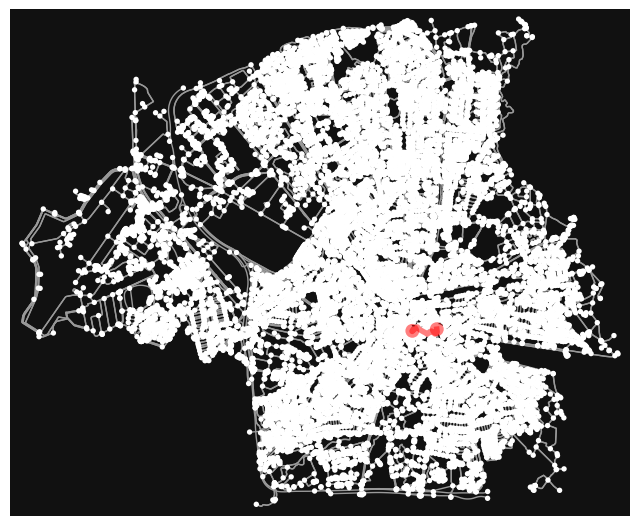

310271224
1283267696
                                                             geometry amenity  \
element id                                                                      
node    250852374                            POINT (5.52632 51.44886)  school   
        1699991564                           POINT (5.44156 51.43905)  school   
        2713602914                            POINT (5.45368 51.4309)  school   
        2717118986                           POINT (5.45731 51.42871)  school   
        2727533688                           POINT (5.44871 51.41487)  school   
...                                                               ...     ...   
way     1228473343  POLYGON ((5.45857 51.44283, 5.45874 51.44264, ...  school   
        1229167348  POLYGON ((5.50056 51.47491, 5.50176 51.47483, ...  school   
        1239211502  POLYGON ((5.44413 51.47413, 5.4447 51.47354, 5...  school   
        1375027985  POLYGON ((5.46187 51.45422, 5.46188 51.45421, ...  school   
       

In [14]:
# For now just simulate a single agent
# Create a random agent

print(len(residences))
print(len(amenities))

import matplotlib as plt

# Get the coordinates of a random residence
rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]
# Get the coordinates of a random workplace
wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]

print(rcoords[1], rcoords[0])
print(wcoords[1], wcoords[0])

orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) 
dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=rcoords[1]) 

print(f"Origin node: {orig}")
print(f"Destination node: {dest}")

route = nx.shortest_path(G, orig, dest, weight='length')
print(f"Route: {route}")
ox.plot_graph_route(G, route)


print(ox.distance.nearest_nodes(
    G, 
    X=rcoords[0],
    Y=rcoords[1],
))
print(ox.distance.nearest_nodes(
    G, 
    X=wcoords[0],
    Y=wcoords[1],
))

print(amenities[amenities['amenity'] == 'school'])




In [15]:
print(ps.dists.calculate_distances(
    ps.dists.G_walk, rcoords, wcoords
))

agent = ps.person(
    residence_coords= rcoords, 
    work_coords= wcoords,
    walk_speed=4,
    seed=seed
)

agent.simulate_day()

Start node: 310271224, End node: 1283267696
1269.3819065895962
Start node: 310271224, End node: 1283267696
Start node: 310271224, End node: 1283267696
Distances from residence to work:
1269.3819065895962
1269.3819065895962
Agent is walking today.
Travel time to work: 19.04072859884394 minutes
No amenity frequencies specified.


np.float64(19.04072859884394)

In [16]:

amenity_types = tags['amenity'] + tags['leisure']

# Function to generate random amenity frequencies
def generate_random_amenity_freqs(amenity_types):
    return {amenity: random.uniform(0.0, 1.0) for amenity in amenity_types}


# Function to create random Person objects
def create_random_persons(num_persons):
    persons = []
    for _ in range(num_persons):
        # Generate random residence and work coordinates
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]  # Example bounding box for Eindhoven
        work_coords = amenities.sample(1).geometry.values[0].centroid.coords[0] if random.random() < 0.8 else None  # 80% chance of having a work location
        
        # Generate random parameters
        walk_speed = random.uniform(3, 5)  # Walking speed in km/h
        bike_speed = random.uniform(8, 12)  # Biking speed in km/h
        bike_freq = random.uniform(0.0, 1.0)  # Frequency of biking
        work_freq = random.uniform(0.0, 1.0)  # Frequency of going to work
        curiosity = random.uniform(0.5, 1.0)  # Curiosity level
        amenity_freqs = generate_random_amenity_freqs(amenity_types)  # Random amenity frequencies
        
        # Create a Person object
        person = ps.person(
            residence_coords=residence_coords,
            work_coords=work_coords,
            walk_speed=walk_speed,
            bike_speed=bike_speed,
            bike_freq=bike_freq,
            work_freq=work_freq,
            amenity_freqs=amenity_freqs,
            curiosity=curiosity,
            seed=seed
        )
        persons.append(person)
    return persons

def create_random_persons_nofreqs(num_persons):
    persons = []
    print("Residences: ", len(residences))
    print("Amenities: ", len(amenities))

    residences_samples = residences.sample(num_persons, replace=True)
    amenities_samples = amenities.sample(num_persons, replace=True)
    for i in range(num_persons):
        # Generate random residence coordinates
        residence_coords = residences_samples.geometry.values[i].centroid.coords[0]
        # Generate random work coordinates
        work_coords = amenities_samples.geometry.values[i].centroid.coords[0]
    
        
        # Generate random parameters
        walk_speed = random.uniform(3, 5)  # Walking speed in km/h
        bike_speed = random.uniform(8, 12)  # Biking speed in km/h
        bike_freq = random.uniform(0.0, 1.0)  # Frequency of biking
        work_freq = 1
        
        # Create a Person object
        person = ps.person(
            residence_coords=residence_coords,
            work_coords=work_coords,
            walk_speed=walk_speed,
            bike_speed=bike_speed,
            bike_freq=bike_freq,
            work_freq=work_freq,
            amenity_freqs=None,
            seed=seed
        )
        persons.append(person)
    return persons


In [ ]:


"""
random_persons = create_random_persons(10)
for i, person in enumerate(random_persons):
    print(f"Person {i+1}:")
    print(f"  Residence: {person.residence_coords}")
    print(f"  Work: {person.work_coords}")
    print(f"  Walk Speed: {person.walk_speed} km/h")
    print(f"  Bike Speed: {person.bike_speed} km/h")
    print(f"  Bike Frequency: {person.bike_freq}")
    print(f"  Work Frequency: {person.work_freq}")
    print(f"  Curiosity: {person.curiosity}")
    print(f"  Amenity Frequencies: {person.amenity_freqs}")
    print()
"""

workplace_coords=(5.476556, 51.441230)
random_persons = create_random_persons_nofreqs(100)

Residences:  3706
Amenities:  703
Start node: 240816717, End node: 42623529
Start node: 240816717, End node: 42623529
Distances from residence to work:
758.5113089303385
758.5113089303385
Start node: 10049282338, End node: 4723775601
Start node: 10049282338, End node: 4723775601
Distances from residence to work:
6144.447191432378
6144.447191432378
Start node: 42610731, End node: 42653715
Start node: 42610731, End node: 42653715
Distances from residence to work:
4706.787697540486
4706.787697540486
Start node: 12032936821, End node: 1484770164
Start node: 12032936821, End node: 1484770164
Distances from residence to work:
756.9199972285872
756.9199972285872
Start node: 42650468, End node: 7659229662
Start node: 42650468, End node: 7659229662
Distances from residence to work:
4710.551798640664
4710.551798640664
Start node: 11014534624, End node: 42585983
Start node: 11014534624, End node: 42585983
Distances from residence to work:
4285.842361833574
4285.842361833574
Start node: 238240396,

In [ ]:
# Create a DataFrame to store the data
df = pd.DataFrame(columns=['lat', 'lon', 'travel_time'])

for person in random_persons:
    # Simulate the person's day
    person.simulate_day()
    travel_time = person.work_travel_time
    lat = person.residence_coords[1]
    lon = person.residence_coords[0]


    # Append the data to the DataFrame
    df.loc[len(df)] = [lat, lon, travel_time]
    
print(df.head())


Agent is biking today.
Travel time to work: 5.117674828895798 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 86.16018826904495 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 66.00068346717697 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 10.6138709364702 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 66.05346537730668 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 31.746811843690494 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 16.099453584721886 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 24.935647376833806 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 45.17183872906515 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 12.712007944

In [ ]:
print(df.describe())
# Create a Folium map centered around the average coordinates
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=13)
# Create a colormap
colormap = cmap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=df['travel_time'].min(), 
    vmax=df['travel_time'].max()
)
# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=5,
        color=colormap(row['travel_time']),
        fill=True,
        fill_opacity=0.6,
        popup=f"Travel Time: {row['travel_time']:.2f} min"
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)
# Save the map to an HTML file
m.save("travel_time_map.html")